## Test Problem: Line of Best Fit

For our test problem, we'll do a three-parameter model which fits a straight line to data. The parameters will be the slope, the intercept, and the scatter about the line; the scatter in this case will be treated as a nuisance parameter.

### The Data

Let's define some data that we'll work with:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
theta_true = (25, 0.5)
xdata = 100 * np.random.random(20)
ydata = theta_true[0] + theta_true[1] * xdata

# add scatter to points
xdata = np.random.normal(xdata, 10)
ydata = np.random.normal(ydata, 10)

In [ ]:
plt.plot(xdata, ydata, 'ok')
plt.xlabel('x')
plt.ylabel('y');

The data are clearly correlated, and we'll assume that we don't know the errors. Let's construct a linear model to fit this data.

### The Model: Slope, Intercept, & Unknown Scatter

Recall that Bayes' theorem gives

$$
P(\theta~|~D) \propto P(D~|~\theta) P(\theta)
$$

Where $D$ represents the observed data, and $\theta$ represents the model.

We'll assume a linear model for our data, parametrized by a slope $\beta$ and a y-intercept $\alpha$:

$$
\hat{y}(x_i~|~\alpha,\beta) = \alpha + \beta x_i
$$

Assuming gaussian errors on the observed y values, the probability for any data point under this model is given by:

$$
P(x_i, y_i~|~\alpha, \beta, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left[\frac{-[y_i - \hat{y}(x_i~|~\alpha, \beta)]^2}{2\sigma^2}\right]
$$

where $\sigma$ here is an unknown measurement error, which we'll treat as a nuisance parameter

Multiplying these for all $i$ gives the likelihood:
$$
P(\{x_i\}, \{y_i\}~|~\alpha, \beta, \sigma) \propto (2\pi\sigma^2)^{-N/2} \exp\left[- \frac{1}{2\sigma^2} \sum_{i-1}^N [y_i - \hat{y}(x_i~|~\alpha,\beta)]^2\right]
$$

### The Prior

Here we're going to be a bit more careful about the choice of prior than we've been in the previous posts. We could simply choose flat priors on $\alpha$, $\beta$, and $\sigma$, but we must keep in mind that **flat priors are not always uninformative priors!** A better choice is to follow Jeffreys and use symmetry and/or maximum entropy to choose maximally noninformative priors. This is the kind of exercise in choosing priors is one that frequentists often complain about as overly subjective, but the approach is well-founded and very well-supported from an information theoretic standpoint.

Why might a flat prior a bad choice? This is perhaps easiest to see in the case of slope.  Let's visualize this by plotting some lines with slopes evenly-spaced between 0 and 10:

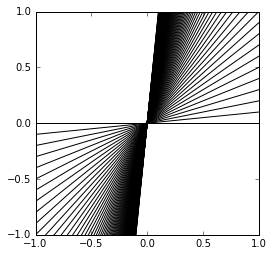

In [3]:
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
x = np.linspace(-1, 1)

for slope in np.arange(0, 10, 0.1):
    plt.plot(x, slope * x, '-k')

ax.axis([-1, 1, -1, 1], aspect='equal');

These lines have evenly-spaced slopes in units of 0.1, yet the higher slopes are bunched together. With a flat prior, you're essentially saying that any one of these slopes is just as likely as another. Due to this bunching seen above, it's clear that a flat prior on slope will highly favor very steep slopes!  A flat prior on slope is not a minimally informative prior, and may end up biasing your result (though with enough data the effect is almost zero).

You might imagine coming up with a better scheme by-hand (perhaps use a flat prior on the angle $\theta$ between the line and the x-axis) but we can be even more rigorous.  The following problem has been well-explored in the Bayesian literature; the best resource I've found is a paper by Jaynes: *Straight Line Fitting: A Bayesian Solution* [(pdf)](http://exordio.qfb.umich.mx/archivos%20pdf%20de%20trabajo%20umsnh/aphilosofia/bayesian%20importantes/leapz.pdf)

#### Prior on Slope and Intercept

If our model is given by

$$
y = \alpha + \beta x
$$

then we can construct a parameter-space probability element $P(\alpha, \beta) ~d\alpha ~d\beta$.

Because $x$ and $y$ are symmetric, we could just as easily use another set of parameters

$$
x = \alpha^\prime + \beta^\prime y
$$

with probability element $Q(\alpha^\prime, \beta^\prime)d\alpha^\prime d\beta^\prime$, where it's easy to show that

$$
(\alpha^\prime,~\beta^\prime) = (- \beta^{-1}\alpha,~\beta^{-1}).
$$

From the Jacobian of the transformation, we can show that

$$
Q(\alpha^\prime, \beta^\prime) = \beta^3 P(\alpha, \beta).
$$

Maintaining the symmetry of the problem requires that this change of variables should not affect the prior probability, so we can write:

$$
\beta^3 P(\alpha, \beta) = P(- \beta^{-1}\alpha, \beta^{-1}).
$$

This is a functional equation which is satisfied by

$$
P(\alpha, \beta) \propto (1 + \beta^2)^{-3/2}.
$$

which is equivalent to saying that $\alpha$ is uniformly distributed, and $\beta$ is distributed uniformly in $\sin\theta$ where $\theta = \tan^{-1}\beta$.

This might surprise you that the slopes are distributed according to $\sin\theta$ rather than uniformly in $\theta$. This $\sin\theta$ term, though, can actually be thought of as coming from the intercept!  If we change variables from $\alpha$ to $\alpha_\perp = \alpha\cos\theta$, then it's straightforward to show that our variables are uniformly distributed in $(\alpha_\perp,~\theta)$. We'll make use of this fact in the PyStan solution below.

#### Prior on $\sigma$

Similarly, we want the prior on $\sigma$ to be invariant to rescalings of the problem (i.e. changing units). So our probability must satisfy

$$
P(\sigma)d\sigma = P(\sigma / c)d\sigma / c.
$$

This is a functional equation satisfied by 

$$
P(\sigma) \propto 1 / \sigma.
$$

This is known as the [Jeffreys Prior](http://en.wikipedia.org/wiki/Jeffreys_prior), after Harold Jeffreys.

#### Putting our Priors Together

Putting these together, we see that symmetry arguments have led to the following minimally informative prior on our model:

$$
P(\alpha, \beta, \sigma) \propto \frac{1}{\sigma}(1 + \beta^2)^{-3/2}
$$

As alluded to above, you could equivalently address this by using flat priors on transformed parameters, namely $(\alpha, \beta, \sigma) \to (\alpha_\perp, \theta, \log\sigma)$, but I personally think the symmetry/maximum entropy approach is cleaner and clearer – it also gives us a chance to demonstrate the definition of nontrivial custom priors within the three packages.

## Solving This Problem in Python

Now that we have the data, the likelihood, and the prior, let's show how to solve this problem in Python using emcee, PyMC, and PyStan. First, though, let's quickly define some convenience routines which will help us visualize the results:

In [4]:
# Create some convenience routines for plotting

def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    
    
def plot_MCMC_model(ax, xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ok')

    alpha, beta = trace[:2]
    xfit = np.linspace(-20, 120, 10)
    yfit = alpha[:, None] + beta[:, None] * xfit
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')


def plot_MCMC_results(xdata, ydata, trace, colors='k'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace)

## PyMC

The [PyMC](http://pymc-devs.github.io/pymc/) package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. 
PyMC by default uses the classic [Metropolis-Hastings](http://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) sampler, one of the earliest MCMC algorithms. For performance, it uses compiled fortran libraries, so it is less trivial to install using tools like pip. My machine has a working fortran compiler, so ``pip install pymc`` worked without a problem (but from working with students, colleagues, and tutorial attendees, I can tell you that few scientists today have a system setup such that this will work out-of-the-box). For folks who don't have a fortran compiler installed, PyMC binaries for many systems can be quite easily [installed with conda](https://conda.binstar.org/pymc).

I should mention that the future [PyMC version 3](https://github.com/pymc-devs/pymc) removes fortran dependence and makes the installation much more streamlined; I've also been told that the API of PyMC 3 is much cleaner, and that performance is much better. Because PyMC 3 is still listed as an alpha release, I've decided to stick with the current supported release for this post:

In [16]:
import pymc
print(pymc.__version__)

2.3.6


In [17]:
# Define the variables needed for the routine, with their prior distributions
alpha = pymc.Uniform('alpha', -100, 100)

@pymc.stochastic(observed=False)
def beta(value=0):
    return -1.5 * np.log(1 + value ** 2)

@pymc.stochastic(observed=False)
def sigma(value=1):
    return -np.log(abs(value))

# Define the form of the model and likelihood
@pymc.deterministic
def y_model(x=xdata, alpha=alpha, beta=beta):
    return alpha + beta * x

y = pymc.Normal('y', mu=y_model, tau=1. / sigma ** 2, observed=True, value=ydata)

# package the full model in a dictionary
model1 = dict(alpha=alpha, beta=beta, sigma=sigma,
              y_model=y_model, y=y)

In [18]:
# run the basic MCMC: we'll do 100000 iterations to match emcee above
S = pymc.MCMC(model1)
S.sample(iter=100000, burn=50000)

 [-----------------100%-----------------] 100000 of 100000 complete in 7.8 sec

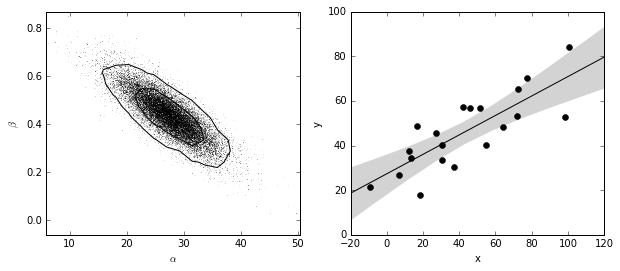

In [19]:
# extract the traces and plot the results
pymc_trace = [S.trace('alpha')[:],
              S.trace('beta')[:],
              S.trace('sigma')[:]]

plot_MCMC_results(xdata, ydata, pymc_trace)